# Manual implementation of an MLP

In [1]:
# Importing libraries
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Open the dataset containing domain names and split into lines
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()
dataset[:8]

['google.com',
 'a-msedge.net',
 'microsoft.com',
 'facebook.com',
 'amazonaws.com',
 'googleapis.com',
 'apple.com',
 'youtube.com']

In [3]:
len(dataset)

4345850

In [4]:
# Create the character set (vocabulary)
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_len = len(charset)
print(ctoi)

{'*': 0, '-': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '_': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'v': 35, 'w': 36, 'x': 37, 'y': 38, 'z': 39}


# Dataset Construction


In [5]:
context_size = 3  # We use a sliding window of characters to predict the next one
X, Y = [], []

for d in dataset[:5]:
    print(d)
    example = list(d) + ['*'] # End each domain with the special char
    context = [0] * context_size # Start with empty context (***)
    for c in example:
        # Build training example: context --> target char
        print(''.join([itoc[x] for x in context]) + ' --> ' + c)
        X.append(context)
        Y.append(ctoi[c])
        # Shift context: drop the first and add the current char
        context = context[1:] + [ctoi[c]]

# Convert to PyTorch tensors for processing
X = torch.tensor(X)
Y = torch.tensor(Y)

google.com
*** --> g
**g --> o
*go --> o
goo --> g
oog --> l
ogl --> e
gle --> .
le. --> c
e.c --> o
.co --> m
com --> *
a-msedge.net
*** --> a
**a --> -
*a- --> m
a-m --> s
-ms --> e
mse --> d
sed --> g
edg --> e
dge --> .
ge. --> n
e.n --> e
.ne --> t
net --> *
microsoft.com
*** --> m
**m --> i
*mi --> c
mic --> r
icr --> o
cro --> s
ros --> o
oso --> f
sof --> t
oft --> .
ft. --> c
t.c --> o
.co --> m
com --> *
facebook.com
*** --> f
**f --> a
*fa --> c
fac --> e
ace --> b
ceb --> o
ebo --> o
boo --> k
ook --> .
ok. --> c
k.c --> o
.co --> m
com --> *
amazonaws.com
*** --> a
**a --> m
*am --> a
ama --> z
maz --> o
azo --> n
zon --> a
ona --> w
naw --> s
aws --> .
ws. --> c
s.c --> o
.co --> m
com --> *


In [6]:
# Checking shapes and data types
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([65, 3]), torch.int64, torch.Size([65]), torch.int64)

In [7]:
X,Y

(tensor([[ 0,  0,  0],
         [ 0,  0, 20],
         [ 0, 20, 28],
         [20, 28, 28],
         [28, 28, 20],
         [28, 20, 25],
         [20, 25, 18],
         [25, 18,  2],
         [18,  2, 16],
         [ 2, 16, 28],
         [16, 28, 26],
         [ 0,  0,  0],
         [ 0,  0, 14],
         [ 0, 14,  1],
         [14,  1, 26],
         [ 1, 26, 32],
         [26, 32, 18],
         [32, 18, 17],
         [18, 17, 20],
         [17, 20, 18],
         [20, 18,  2],
         [18,  2, 27],
         [ 2, 27, 18],
         [27, 18, 33],
         [ 0,  0,  0],
         [ 0,  0, 26],
         [ 0, 26, 22],
         [26, 22, 16],
         [22, 16, 31],
         [16, 31, 28],
         [31, 28, 32],
         [28, 32, 28],
         [32, 28, 19],
         [28, 19, 33],
         [19, 33,  2],
         [33,  2, 16],
         [ 2, 16, 28],
         [16, 28, 26],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 14],
         [19, 14, 16],
         [14, 16, 18],
         [1

## The Neural Network
The network we are going to implement is similar to the one presented in this paper. The main difference is that we will implement the language model at the character level rather than at the word level, as done in the paper.


https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

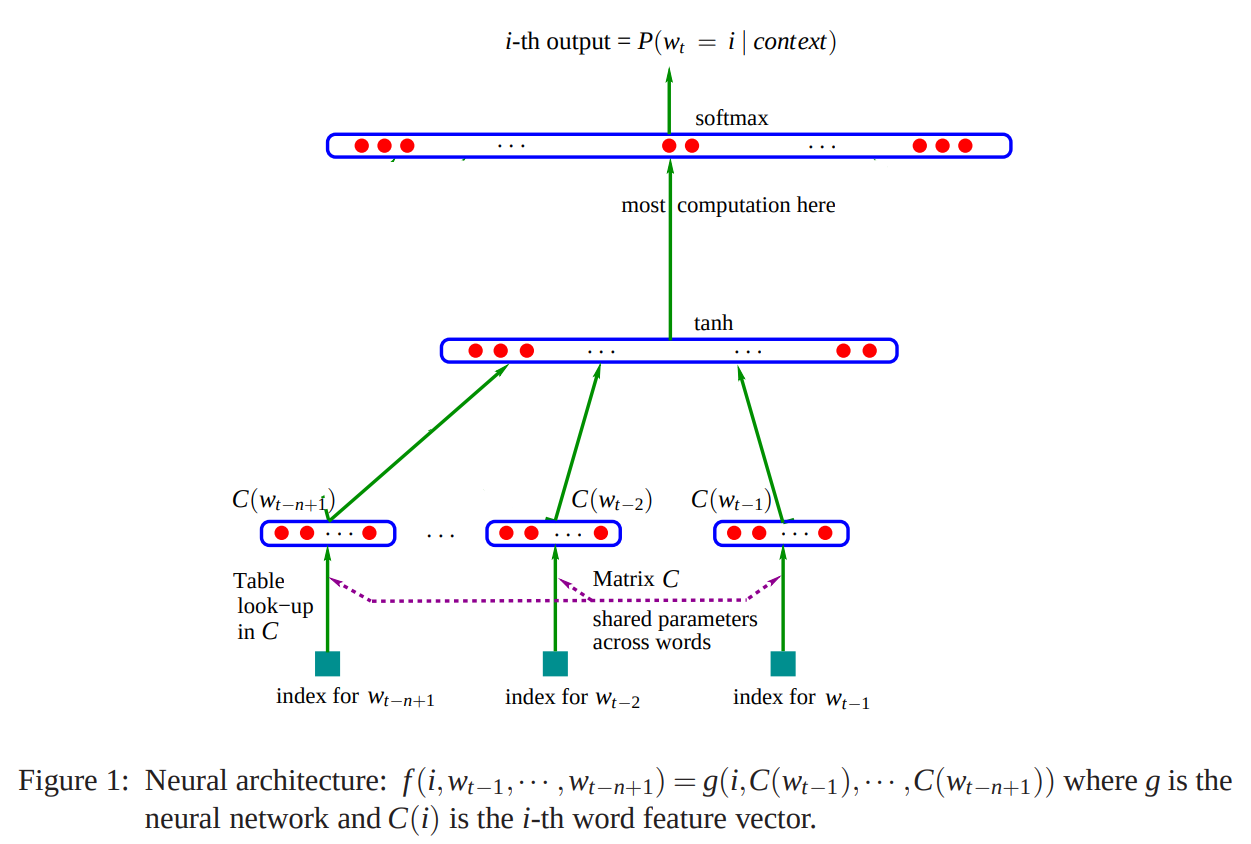

In [8]:
# Model initialization

g = torch.Generator().manual_seed(42)
emb_d = 2 # Dimension of character embedding
C = torch.randn(charset_len, emb_d, generator=g)
emb = C[X]

In [9]:
emb.view((65,6))

tensor([[ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -1.5576,  0.9956],
        [ 1.9269,  1.4873, -1.5576,  0.9956, -1.4032,  0.0360],
        [-1.5576,  0.9956, -1.4032,  0.0360, -1.4032,  0.0360],
        [-1.4032,  0.0360, -1.4032,  0.0360, -1.5576,  0.9956],
        [-1.4032,  0.0360, -1.5576,  0.9956,  0.0780,  0.5258],
        [-1.5576,  0.9956,  0.0780,  0.5258,  0.3189, -0.4245],
        [ 0.0780,  0.5258,  0.3189, -0.4245,  0.6784, -1.2345],
        [ 0.3189, -0.4245,  0.6784, -1.2345, -1.3847, -0.8712],
        [ 0.6784, -1.2345, -1.3847, -0.8712, -1.4032,  0.0360],
        [-1.3847, -0.8712, -1.4032,  0.0360, -0.4880,  1.1914],
        [ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -0.2316,  0.0418],
        [ 1.9269,  1.4873, -0.2316,  0.0418,  0.9007, -2.1055],
        [-0.2316,  0.0418,  0.9007, -2.1055, -0.4880,  1.1914],
        [ 0.9007, -2.1055, -0.4880,  1.1

In [10]:
input_size = 6  # context size * emb_d
n_hidden = 128  #  hiddend neurons
W1 = torch.randn(input_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W1.shape, b1.shape

(torch.Size([6, 128]), torch.Size([128]))

In [11]:
#Shape view
emb1 = emb.view(-1,input_size)
(emb1 @ W1).shape, b1.shape

(torch.Size([65, 128]), torch.Size([128]))

In [12]:
# 65, 128
#  1, 128

h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
h.shape

torch.Size([65, 128])

In [13]:
# Second Layer
W2 = torch.randn(n_hidden, charset_len, generator=g)
b2 = torch.randn(charset_len, generator=g)

In [14]:
# Calculating loss step-by-step (cross entropy)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(axis=1, keepdims=True)
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(21.1386)

In [15]:
# Reproducibility
g = torch.Generator().manual_seed(42)

# Hyperparameters
emb_d = 2            # Embedding dimension for each character
context_size = 3     # Context size (e.g., trigrams)
input_size = context_size * emb_d
n_hidden = 128       # Number of neurons in the hidden layer

# Model definition
C  = torch.randn(charset_len, emb_d, generator=g)        # Character embedding matrix
W1 = torch.randn(input_size, n_hidden, generator=g)     # Hidden layer weights
b1 = torch.randn(n_hidden, generator=g)                  # Hidden layer bias
W2 = torch.randn(n_hidden, charset_len, generator=g)    # Output layer weights
b2 = torch.randn(charset_len, generator=g)               # Output layer bias

# Trainable parameters
parameters = [C, W1, b1, W2, b2]


In [16]:
sum(p.nelement() for p in parameters)

6136

In [17]:
for p in parameters:
    p.requires_grad = True

In [18]:
# forward pass with loss 
emb = C[X]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(axis=1, keepdims=True)
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(21.1386, grad_fn=<NegBackward0>)

In [19]:
F.cross_entropy(logits, Y)

tensor(21.1386, grad_fn=<NllLossBackward0>)

In [20]:
# forward pass using F.cross_entropy
emb = C[X]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(21.1386, grad_fn=<NllLossBackward0>)

In [21]:
# backward pass
for p in parameters:
    p.grad = None
loss.backward()

In [22]:
# update
for p in parameters:
    p.data += -0.1 * p.grad

In [23]:
# Training loop
for _ in range(1000):
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) # Efficient loss calculation
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Simple Gradient Descent update
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Loss after 1000 steps: {loss.item()}")

Loss after 1000 steps: 0.1307358741760254


In [24]:
# Inference: Generating new domain names with the trained model
g = torch.Generator().manual_seed(42)

for i in range(10):
    context = [0] * context_size
    out = []
    while True:
        # Model predicts next char based on current context
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # Sample from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itoc[ix])
        
        # Stop if we hit the '*' end token
        if ix == 0:
            break
    print(''.join(out[:-1]))

google.com
microsoft.com
amazonaws.com
google.com
google.com
microsoft.com
facebook.com
a-msedge.net
google.com
amazonbrs0dge.net


In [25]:
-np.log(1/40)

np.float64(3.6888794541139363)

## Some Adjustments
Let’s expand the dataset.


In [26]:
context_size = 3  # Context size or how many characters we will use to predict the next one
X, Y = [], []

for d in dataset[:100000]:
    example = list(d) + ['*']
    context = [0] * context_size
    for c in example:
        X.append(context)
        Y.append(ctoi[c])
        context = context[1:] + [ctoi[c]]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [27]:
#New Shapes
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([1361270, 3]), torch.int64, torch.Size([1361270]), torch.int64)

In [28]:
# we redefine the model...
g = torch.Generator().manual_seed(42)
emb_d = 2  # Number of embedding dimensions
input_size = 6  # context size * emb_d
n_hidden = 128  # Number of neurons in the hidden layer

# Model definition
C = torch.randn(charset_len, emb_d, generator=g)
W1 = torch.randn(input_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, charset_len, generator=g)
b2 = torch.randn(charset_len, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)


6136

In [29]:
minibatch_size = 64
loss_log = []

for _ in range(2000):
    # training loop in mini-batches
    ix = torch.randint(0, len(X), (minibatch_size,))
    
    # forward pass using F.cross_entropy
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    loss_log.append(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


3.040562868118286


In [30]:
# Inference
g = torch.Generator().manual_seed(42)

for i in range(20):
    context = [20, 26, 26] 
    ix = 0
    out = []
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out[:-1]))


gsad.cdsgat
i1aaaisitn.bamvddiacrnua.rrtegostidvp.fogal-pfto
aennbii.ip
ituap-t.com
aiu.oezioii.iutisbeiasoa.ro
.mdgrbnfmasto
ieaisaiiwvrtidrifpuapsdlvdi
rrziitigihnitt.brtininivnru
imrt.or
itrrnlitsoarrif.cov
ozitnusogr1oat
sisrpc
.com
olin.rene

yrtu
prnidnwupriisolniwp
.comji.idmais.cpm
erit.it


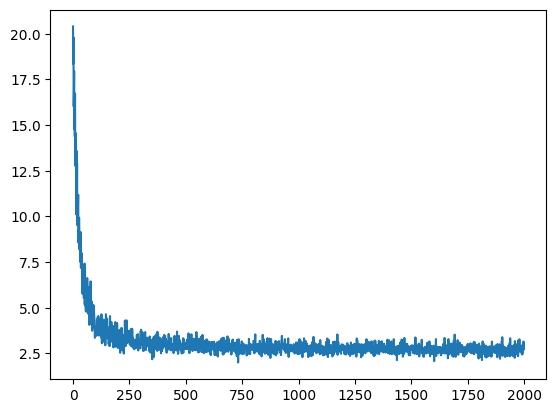

In [31]:
#Loss visualization
plt.plot(loss_log)

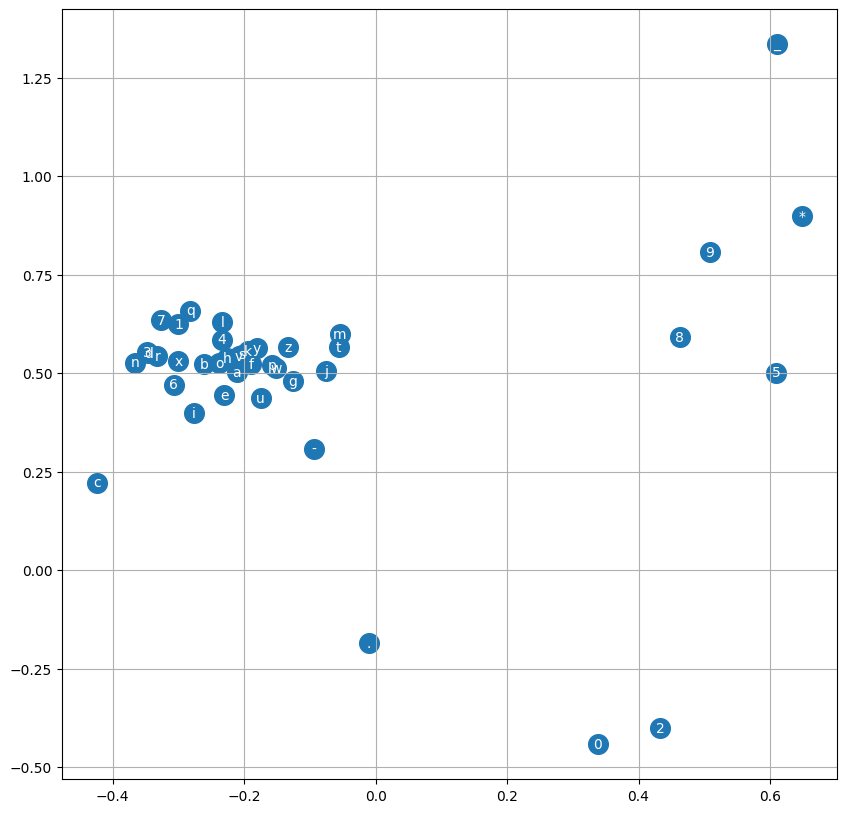

In [32]:
# Visualizing the 2D embeddings of characters
# This shows which characters the model thinks are similar
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid('minor')